In [1]:
from pathlib import Path
import yaml
import numpy as np
from torch.utils.data import DataLoader

from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import random_split, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from hydra.utils import instantiate

import os
import torch
import sys

sys.path.append("/home/erogullari/Workspace/cav-disentanglement")
from datasets import get_elements_dataset

In [2]:
filename = Path("/home/erogullari/Workspace/cav-disentanglement/configs/dataset/elements_standart.yaml")
device = "cuda"

with open(filename, "r") as fp:
    config = OmegaConf.load(fp)

In [3]:
print("Number of classes:", len(config['class_configs']))   # type: ignore

Number of classes: 153


In [4]:
dataset = instantiate(config)
len(dataset), len(dataset.class_configs)

(10000, 153)

In [5]:
concept_names = dataset.get_concept_names()
for i, name in enumerate(concept_names):
    print(f"Concept {i}: {name}")

Concept 0: shape:circle
Concept 1: shape:cross
Concept 2: shape:plus
Concept 3: shape:square
Concept 4: shape:triangle
Concept 5: color:blue
Concept 6: color:cyan
Concept 7: color:green
Concept 8: color:magenta
Concept 9: color:red
Concept 10: color:yellow
Concept 11: texture:solid
Concept 12: texture:spots_chequerboard
Concept 13: texture:spots_polka
Concept 14: texture:spots_random
Concept 15: texture:spots_regular
Concept 16: texture:stripes_diagonal
Concept 17: texture:stripes_diagonal_alt
Concept 18: texture:stripes_horizontal
Concept 19: texture:stripes_vertical


In [6]:
for corr in config.correlations:
    print(corr["concept_names"], f"[{concept_names.index(corr['concept_names'][0])}, {concept_names.index(corr['concept_names'][1])}]")

['shape:triangle', 'texture:stripes_horizontal'] [4, 18]
['shape:circle', 'texture:stripes_vertical'] [0, 19]
['shape:square', 'texture:spots_random'] [3, 14]
['color:red', 'shape:plus'] [9, 2]
['color:blue', 'shape:cross'] [5, 1]


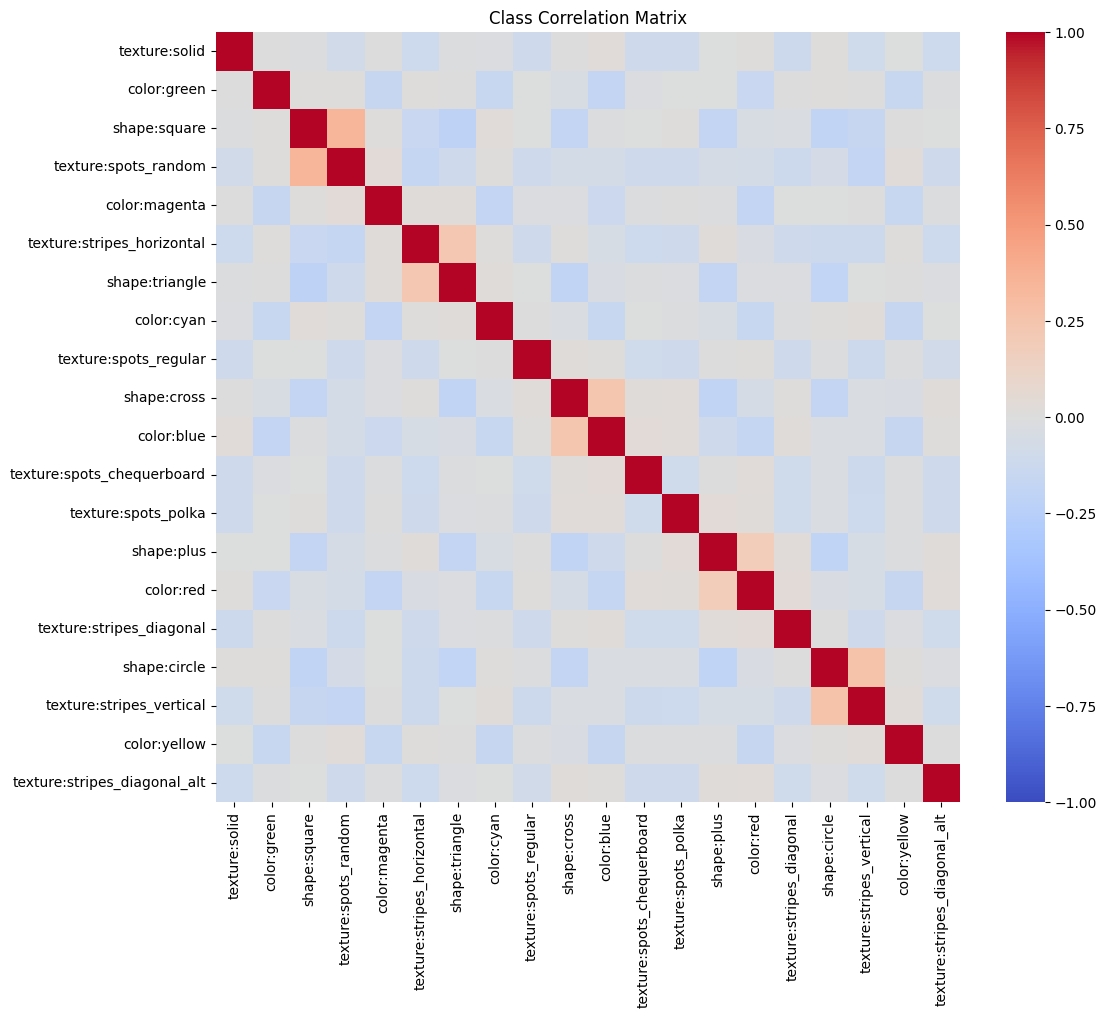

In [7]:
from utils.visualizations import visualize_sim_matrix

concept_names = dataset.get_concept_names()
labels = dataset.get_labels()
mean_centered = labels - labels.mean(dim=0, keepdim=True)
cov_matrix = mean_centered.T @ mean_centered / (labels.shape[0] - 1)
std_dev = labels.std(dim=0, keepdim=True)
correlation_matrix = cov_matrix / (std_dev.T @ std_dev)
visualize_sim_matrix(correlation_matrix, concept_names, title="Class Correlation Matrix")

In [8]:
from models import get_lenet5, get_resnet18, get_simplenet

in_channels = 3
input_size = config.image_size
model_name = "simplenet"
# model = get_lenet5(n_class=len(dataset.class_configs), in_channels=in_channels, input_size=input_size).to(device)
model = get_simplenet(n_class=len(dataset.class_configs), in_channels=in_channels, input_size=input_size).to(device)
# model = get_resnet18(n_class=len(dataset.class_configs), pretrained=False).to(device)

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from torchmetrics import Precision, Recall, F1Score, Accuracy

class ElementClassifier(pl.LightningModule):
    def __init__(self, model, num_classes, learning_rate=1e-3):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        
        # Multi-label metrics
        self.accuracy = Accuracy(task="multilabel", num_labels=num_classes, average="macro")
        self.precision = Precision(task="multilabel", num_labels=num_classes, average="macro")
        self.recall = Recall(task="multilabel", num_labels=num_classes, average="macro")
        self.f1 = F1Score(task="multilabel", num_labels=num_classes, average="macro")
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = BCEWithLogitsLoss()(logits, y.float())
        preds = (torch.sigmoid(logits) > 0.5).float()
        self.log("train_precision", self.precision(preds, y.int()))
        self.log("train_recall", self.recall(preds, y.int()))
        self.log("train_f1", self.f1(preds, y.int()))
        self.log("train_accuracy", self.accuracy(preds, y.int()))
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = BCEWithLogitsLoss()(logits, y.float())
        preds = (torch.sigmoid(logits) > 0.5).float()
        
        self.log("val_loss", loss)
        self.log("val_precision", self.precision(preds, y.int()))
        self.log("val_recall", self.recall(preds, y.int()))
        self.log("val_f1", self.f1(preds, y.int()))
        self.log("val_accuracy", self.accuracy(preds, y.int()))
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
wandb_api_key = "null"
wandb_project_name = "elements-training-1"

os.environ["WANDB_API_KEY"] = wandb_api_key
wandb_logger = WandbLogger(
    project=wandb_project_name,
    # api_key=wandb_api_key,
    name=f"{model_name}-bce"
)

In [11]:
# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename=f"{model_name}" + "-bce-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=3,
    verbose=True
)

lightning_model = ElementClassifier(model, len(dataset.class_configs))
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Train size: 8000, Val size: 2000


In [13]:
trainer.fit(lightning_model, train_loader, val_loader)

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#t

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | SimpleNet           | 344 K  | train
1 | accuracy  | MultilabelAccuracy  | 0      | train
2 | precision | MultilabelPrecision | 0      | train
3 | recall    | MultilabelRecall    | 0      | train
4 | f1        | MultilabelF1Score   | 0      | train
----------------------------------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params
1.379     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/erogullari/miniconda3/envs/xai/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 250/250 [00:52<00:00,  4.74it/s, v_num=bnpw]

Epoch 0, global step 250: 'val_loss' reached 0.13578 (best 0.13578), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=00-val_loss=0.14.ckpt' as top 3


Epoch 1: 100%|██████████| 250/250 [00:54<00:00,  4.55it/s, v_num=bnpw]

Epoch 1, global step 500: 'val_loss' reached 0.12510 (best 0.12510), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=01-val_loss=0.13.ckpt' as top 3


Epoch 2: 100%|██████████| 250/250 [00:54<00:00,  4.59it/s, v_num=bnpw]

Epoch 2, global step 750: 'val_loss' reached 0.10916 (best 0.10916), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=02-val_loss=0.11.ckpt' as top 3


Epoch 3: 100%|██████████| 250/250 [00:53<00:00,  4.66it/s, v_num=bnpw]

Epoch 3, global step 1000: 'val_loss' reached 0.09574 (best 0.09574), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=03-val_loss=0.10.ckpt' as top 3


Epoch 4: 100%|██████████| 250/250 [00:53<00:00,  4.71it/s, v_num=bnpw]

Epoch 4, global step 1250: 'val_loss' reached 0.08282 (best 0.08282), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=04-val_loss=0.08.ckpt' as top 3


Epoch 5: 100%|██████████| 250/250 [00:52<00:00,  4.74it/s, v_num=bnpw]

Epoch 5, global step 1500: 'val_loss' reached 0.07163 (best 0.07163), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=05-val_loss=0.07.ckpt' as top 3


Epoch 6: 100%|██████████| 250/250 [00:52<00:00,  4.74it/s, v_num=bnpw]

Epoch 6, global step 1750: 'val_loss' reached 0.05851 (best 0.05851), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=06-val_loss=0.06.ckpt' as top 3


Epoch 7: 100%|██████████| 250/250 [00:52<00:00,  4.72it/s, v_num=bnpw]

Epoch 7, global step 2000: 'val_loss' reached 0.05132 (best 0.05132), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=07-val_loss=0.05.ckpt' as top 3


Epoch 8: 100%|██████████| 250/250 [00:52<00:00,  4.73it/s, v_num=bnpw]

Epoch 8, global step 2250: 'val_loss' reached 0.06981 (best 0.05132), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=08-val_loss=0.07.ckpt' as top 3


Epoch 9: 100%|██████████| 250/250 [00:53<00:00,  4.70it/s, v_num=bnpw]

Epoch 9, global step 2500: 'val_loss' reached 0.05681 (best 0.05132), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=09-val_loss=0.06.ckpt' as top 3


Epoch 10: 100%|██████████| 250/250 [00:54<00:00,  4.61it/s, v_num=bnpw]

Epoch 10, global step 2750: 'val_loss' reached 0.02772 (best 0.02772), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=10-val_loss=0.03.ckpt' as top 3


Epoch 11: 100%|██████████| 250/250 [00:53<00:00,  4.67it/s, v_num=bnpw]

Epoch 11, global step 3000: 'val_loss' reached 0.02241 (best 0.02241), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=11-val_loss=0.02.ckpt' as top 3


Epoch 12: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s, v_num=bnpw]

Epoch 12, global step 3250: 'val_loss' reached 0.01895 (best 0.01895), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=12-val_loss=0.02.ckpt' as top 3


Epoch 13: 100%|██████████| 250/250 [00:53<00:00,  4.67it/s, v_num=bnpw]

Epoch 13, global step 3500: 'val_loss' reached 0.01754 (best 0.01754), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=13-val_loss=0.02.ckpt' as top 3


Epoch 14: 100%|██████████| 250/250 [00:52<00:00,  4.74it/s, v_num=bnpw]

Epoch 14, global step 3750: 'val_loss' reached 0.01385 (best 0.01385), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=14-val_loss=0.01.ckpt' as top 3


Epoch 15: 100%|██████████| 250/250 [00:52<00:00,  4.72it/s, v_num=bnpw]

Epoch 15, global step 4000: 'val_loss' reached 0.01128 (best 0.01128), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=15-val_loss=0.01.ckpt' as top 3


Epoch 16: 100%|██████████| 250/250 [00:53<00:00,  4.65it/s, v_num=bnpw]

Epoch 16, global step 4250: 'val_loss' reached 0.01072 (best 0.01072), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=16-val_loss=0.01.ckpt' as top 3


Epoch 17: 100%|██████████| 250/250 [00:53<00:00,  4.63it/s, v_num=bnpw]

Epoch 17, global step 4500: 'val_loss' was not in top 3


Epoch 18: 100%|██████████| 250/250 [00:52<00:00,  4.77it/s, v_num=bnpw]

Epoch 18, global step 4750: 'val_loss' reached 0.00666 (best 0.00666), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=18-val_loss=0.01.ckpt' as top 3


Epoch 19: 100%|██████████| 250/250 [00:53<00:00,  4.69it/s, v_num=bnpw]

Epoch 19, global step 5000: 'val_loss' was not in top 3


Epoch 20: 100%|██████████| 250/250 [00:54<00:00,  4.63it/s, v_num=bnpw]

Epoch 20, global step 5250: 'val_loss' reached 0.00503 (best 0.00503), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=20-val_loss=0.01.ckpt' as top 3


Epoch 21: 100%|██████████| 250/250 [00:53<00:00,  4.69it/s, v_num=bnpw]

Epoch 21, global step 5500: 'val_loss' reached 0.00548 (best 0.00503), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=21-val_loss=0.01.ckpt' as top 3


Epoch 22: 100%|██████████| 250/250 [00:52<00:00,  4.78it/s, v_num=bnpw]

Epoch 22, global step 5750: 'val_loss' was not in top 3


Epoch 23: 100%|██████████| 250/250 [00:51<00:00,  4.84it/s, v_num=bnpw]

Epoch 23, global step 6000: 'val_loss' reached 0.00365 (best 0.00365), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=23-val_loss=0.00.ckpt' as top 3


Epoch 24: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s, v_num=bnpw]

Epoch 24, global step 6250: 'val_loss' reached 0.00328 (best 0.00328), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=24-val_loss=0.00.ckpt' as top 3


Epoch 25: 100%|██████████| 250/250 [00:53<00:00,  4.63it/s, v_num=bnpw]

Epoch 25, global step 6500: 'val_loss' reached 0.00274 (best 0.00274), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=25-val_loss=0.00.ckpt' as top 3


Epoch 26: 100%|██████████| 250/250 [00:53<00:00,  4.65it/s, v_num=bnpw]

Epoch 26, global step 6750: 'val_loss' reached 0.00244 (best 0.00244), saving model to '/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=26-val_loss=0.00.ckpt' as top 3


Epoch 27: 100%|██████████| 250/250 [00:53<00:00,  4.65it/s, v_num=bnpw]

Epoch 27, global step 7000: 'val_loss' was not in top 3


Epoch 28: 100%|██████████| 250/250 [00:53<00:00,  4.70it/s, v_num=bnpw]

Epoch 28, global step 7250: 'val_loss' was not in top 3


Epoch 29: 100%|██████████| 250/250 [00:53<00:00,  4.63it/s, v_num=bnpw]

Epoch 29, global step 7500: 'val_loss' was not in top 3
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 250/250 [00:53<00:00,  4.63it/s, v_num=bnpw]


In [18]:
# Get predictions on validation set
lightning_model.eval().to(device)
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = lightning_model(x)
        preds = torch.sigmoid(logits).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [19]:
accuracy = ((all_preds > .5) * 1 == all_labels).mean()  # type: ignore
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9988


In [20]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix

num_classes = all_preds.shape[1]

# per-class ROC + precision/recall at 0.5
fpr = {}
tpr = {}
roc_auc = {}
precision_per = {}
recall_per = {}
support_per = {}

for i in range(num_classes):
    y_true = all_labels[:, i].astype(int)
    y_score = all_preds[:, i]
    y_pred = (y_score > 0.5).astype(int)

    # precision / recall at threshold 0.5 (sklearn)
    precision_per[i] = precision_score(y_true, y_pred, zero_division=0)
    recall_per[i] = recall_score(y_true, y_pred, zero_division=0)

    # support and confusion for diagnostics
    support_per[i] = int(y_true.sum())
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    print(f"cls {i}: support={support_per[i]}  TP={tp}  FP={fp}  FN={fn}  TN={tn}  precision={precision_per[i]:.3f}  recall={recall_per[i]:.3f}")

# macro averages (use sklearn to match torchmetrics)
precision_macro = precision_score(all_labels.astype(int), (all_preds > 0.5).astype(int), average="macro", zero_division=0)
recall_macro = recall_score(all_labels.astype(int), (all_preds > 0.5).astype(int), average="macro", zero_division=0)


print("\nSummary:")
print(f"Macro Precision@0.5: {precision_macro:.3f}")
print(f"Macro Recall@0.5:    {recall_macro:.3f}")

cls 0: support=16  TP=16  FP=1  FN=0  TN=1983  precision=0.941  recall=1.000
cls 1: support=20  TP=20  FP=0  FN=0  TN=1980  precision=1.000  recall=1.000
cls 2: support=13  TP=13  FP=2  FN=0  TN=1985  precision=0.867  recall=1.000
cls 3: support=160  TP=158  FP=0  FN=2  TN=1840  precision=1.000  recall=0.988
cls 4: support=20  TP=19  FP=0  FN=1  TN=1980  precision=1.000  recall=0.950
cls 5: support=15  TP=15  FP=5  FN=0  TN=1980  precision=0.750  recall=1.000
cls 6: support=12  TP=11  FP=3  FN=1  TN=1985  precision=0.786  recall=0.917
cls 7: support=184  TP=184  FP=0  FN=0  TN=1816  precision=1.000  recall=1.000
cls 8: support=22  TP=22  FP=0  FN=0  TN=1978  precision=1.000  recall=1.000
cls 9: support=15  TP=15  FP=0  FN=0  TN=1985  precision=1.000  recall=1.000
cls 10: support=19  TP=19  FP=2  FN=0  TN=1979  precision=0.905  recall=1.000
cls 11: support=175  TP=175  FP=0  FN=0  TN=1825  precision=1.000  recall=1.000
cls 12: support=22  TP=18  FP=0  FN=4  TN=1978  precision=1.000  rec

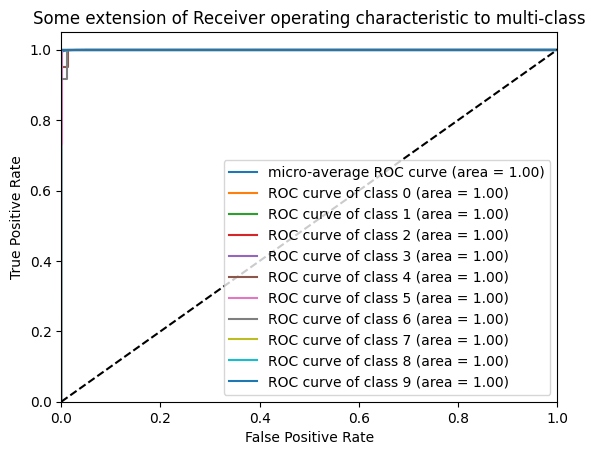

In [21]:
num_classes_roc = 10

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes_roc):

    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(num_classes_roc):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [22]:
ckpt_path = "/home/erogullari/Workspace/cav-disentanglement/notebooks/checkpoints/simplenet-bce-epoch=26-val_loss=0.00.ckpt"
backbone = get_simplenet(n_class=153, in_channels=3, input_size=224, pretrained=False)
classifier = ElementClassifier.load_from_checkpoint(ckpt_path, model=backbone, num_classes=153)
classifier.eval().cpu()
save_path = f"/media/erogullari/checkpoints/checkpoint_{model_name}_elements.pth"
torch.save(classifier.model.state_dict(), save_path)

In [23]:
list(model.named_modules())

[('',
  SimpleNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pa